<a href="https://colab.research.google.com/github/purvikabajaj/Convolutional-Neural-Networks/blob/master/CNN_Cats_vs_Dogs_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 6.9MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyunpack import Archive
Archive('/content/drive/My Drive/Colab Notebooks/CatvsDogs.rar').extractall('/content')

In [ ]:
import os
filenames = os.listdir('/content/train')

categories=[]
for f_name in filenames:
  category = f_name.split('.')[0]
  if category =='dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
df.head()

,filename,category
0,cat.10781.jpg,0
1,cat.4333.jpg,0
2,dog.5852.jpg,1
3,cat.10773.jpg,0
4,dog.11606.jpg,1


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df['category'] = df['category'].replace({0:'cat',1:'dog'})
train_df, validate_df = train_test_split(df, test_size = 0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validation_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
print(total_train)
total_validation = validate_df.shape[0]
print(total_validation)

17500
7500


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    zoom_range = 0.2,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    '/content/train',
    x_col = 'filename',
    y_col = 'category',
    target_size = (64,64),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 17500 validated image filenames belonging to 2 classes.


(64, 64, 3)


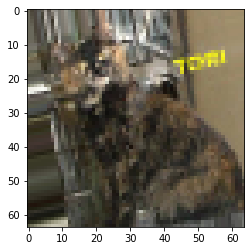

In [ ]:
x,y = train_generator.next()

for i in range(0,1):
  image = x[i]
  plt.imshow(image)
  print(image.shape)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    '/content/train',
    x_col = 'filename',
    y_col = 'category', 
    target_size = (64,64),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 7500 validated image filenames belonging to 2 classes.


(64, 64, 3)


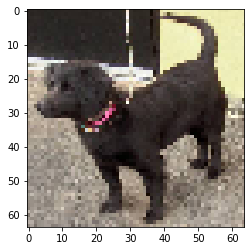

In [ ]:
x,y = validation_generator.next()

for i in range(0,1):
  image = x[i]
  plt.imshow(image)
  print(image.shape)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
model = VGG16(weights = 'imagenet', include_top = False)

x = model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)

model_vgg = Model(model.input, x)

for layer in model.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model_vgg.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
import tensorflow as tf

In [ ]:
batch_size=32
history = model_vgg.fit_generator(
    train_generator,
    steps_per_epoch = total_train//batch_size,
    epochs = 15,
    validation_data = validation_generator,
    verbose=1,
    validation_steps = total_validation//batch_size,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
546/546 [==============================] - 88s 161ms/step - loss: 0.5103 - accuracy: 0.7432 - val_loss: 0.4486 - val_accuracy: 0.7871
Epoch 2/15
546/546 [==============================] - 86s 158ms/step - loss: 0.4778 - accuracy: 0.7687 - val_loss: 0.4285 - val_accuracy: 0.7963
Epoch 3/15
546/546 [==============================] - 86s 158ms/step - loss: 0.4583 - accuracy: 0.7745 - val_loss: 0.4513 - val_accuracy: 0.7827
Epoch 4/15
546/546 [==============================] - 87s 159ms/step - loss: 0.4550 - accuracy: 0.7809 - val_loss: 0.4369 - val_accuracy: 0.7910
Epoch 5/15
546/546 [==============================] - 87s 159ms/step - loss: 0.4456 - accuracy: 0.7864 - val_loss: 0.4184 - val_accuracy: 0.7994
Epoch 6/15
546/546 [==============================] - 85s 155ms/step - loss: 0.4364 - accuracy: 0.7925 - val_loss: 0.4206 - val_accuracy: 0.7986
Epoch 7/15
546/546 [==============================] - 

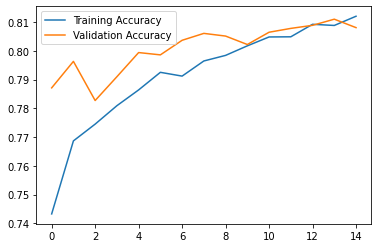

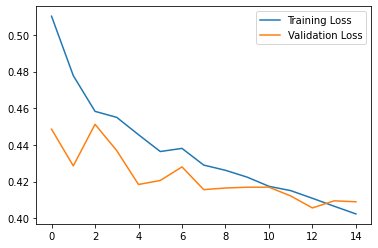

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()